# Underestand Visitors with YOLO-World
---
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/supervision/blob/develop/docs/notebooks/zero-shot-object-detection-with-yolo-world.ipynb)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/what-is-yolo-world/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/AILab-CVC/YOLO-World)
[![arXiv](https://img.shields.io/badge/arXiv-2401.17270-b31b1b.svg)](https://arxiv.org/abs/2401.17270)

Click the `Open in Colab` button to run the cookbook on Google Colab.

<br>

Understanding visitor behavior in malls, stores, and events is key to improving services and customer experience. With YOLO-World, we can now instantly identify specific visitor traits, like clothing colors or behaviors, without needing pre-trained data. This flexibility allows for tailored insights, enhancing how we manage and engage with visitors in any physical space.

![visualization results of referring object detection](https://storage.googleapis.com/adonaivera_certified/test.jpeg)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/Users/adonaivera/Documents/supervision/docs/notebooks


## Install required packages

In this guide, we utilize two Python packages: `inference`, for executing zero-shot object detection using YOLO-World, and `supervision`, for post-processing and visualizing the detected objects.

In [7]:
!pip install -q inference-gpu[yolo-world]==0.9.12rc1

zsh:1: no matches found: inference-gpu[yolo-world]==0.9.12rc1


In [5]:
!pip install -q supervision==0.19.0rc3


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Imports

In [8]:
import cv2
import supervision as sv

from tqdm import tqdm
from inference.models.yolo_world.yolo_world import YOLOWorld

ModuleNotFoundError: No module named 'tqdm'

## Download example data

In [6]:
!wget -P {HOME} -q https://storage.googleapis.com/adonaivera_certified/test.jpeg
!wget -P {HOME} -q https://storage.googleapis.com/adonaivera_certified/test_demo1.mp4

In [7]:
SOURCE_IMAGE_PATH = f"{HOME}/test.jpeg"
SOURCE_VIDEO_PATH = f"{HOME}/test_demo1.mp4"

**NOTE:** If you want to run the cookbook using your own file as input, simply upload video to Google Colab and replace `SOURCE_IMAGE_PATH` and `SOURCE_VIDEO_PATH` with the path to your file.

## Run Object Detection

The Inference package provides the YOLO-World model in three versions: `S`, `M`, and `L`. You can load them by defining model_id as `yolo_world/s`, `yolo_world/m`, and `yolo_world/l`, respectively. The `ROBOFLOW_API_KEY` is not required to utilize this model.







In [8]:
model = YOLOWorld(model_id="yolo_world/l")

YOLO-World is a zero-shot model, enabling object detection without any training. You only need to define a prompt as a list of classes (things) you are searching for.

In [9]:
classes = ["person"]
model.set_classes(classes)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 106MiB/s]


We perform detection on our sample image. Then, we convert the result into a [`sv.Detections`](https://supervision.roboflow.com/latest/detection/core/) object, which will be useful in the later parts of the cookbook.

In [10]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

The results we've obtained can be easily visualized with [`sv.BoundingBoxAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.BoundingBoxAnnotator) and [`sv.LabelAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.LabelAnnotator). We can adjust parameters such as line thickness, text scale, line and text color allowing for a highly tailored visualization experience.

In [11]:
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

By default, `sv.LabelAnnotator` displays only the names of objects. To also view the confidence levels associated with each detection, we must define custom `labels` and pass them to `sv.LabelAnnotator`.

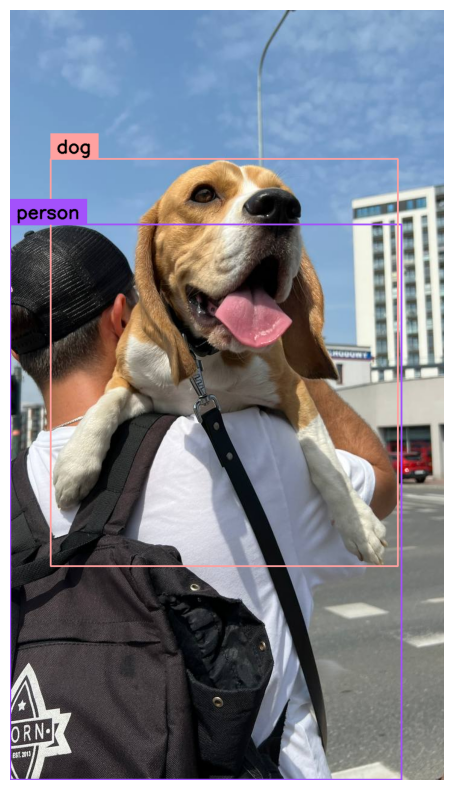

In [12]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

Now, think that you are the marketing director of a big retail company and you need to underestand the behaviour of your visitors, one of your big stores in your mall its a company that sells hats and backpack, and you need to know how many people thast goes to the event is weating hats and backpack, you can use yolo-world to fit that without any training.

In [ ]:

classes = ["person", "backpack", "persons with backpack", "persons with hats", "hats"]
model.set_classes(classes)

In [ ]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

Now, think that you would like to go bigger, and would you like to implement this dynamics models directly to the mall, that's why you don't process an image, you process a full video ...

## Video Processing

The [`get_video_frames_generator`](https://supervision.roboflow.com/latest/utils/video/#supervision.utils.video.get_video_frames_generator) enables us to easily iterate over video frames. Let's create a video generator for our sample input file and display its first frame on the screen.

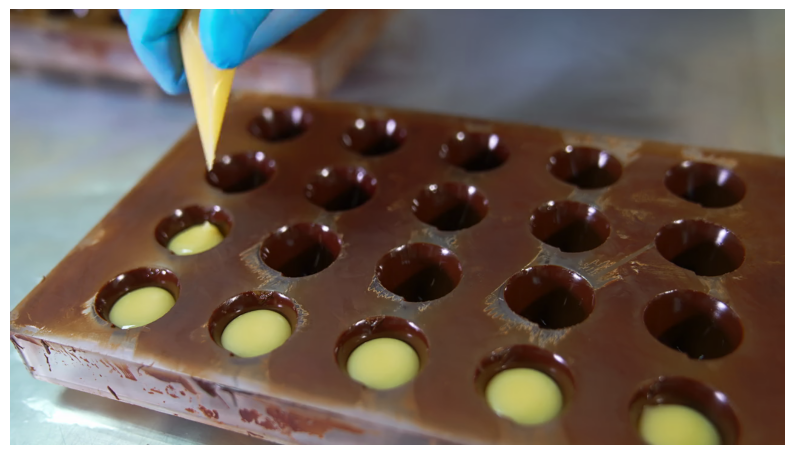

In [17]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (10, 10))

Let's update our list of classes. This time we are looking for `yellow filling`. The rest of the code performing detection, filtering and visualization remains unchanged.

In [23]:
classes = ["person", "backpack", "persons with backpack", "persons with hats", "hats"]

model.set_classes(classes)

In [38]:
results = model.infer(frame, confidence=0.002)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

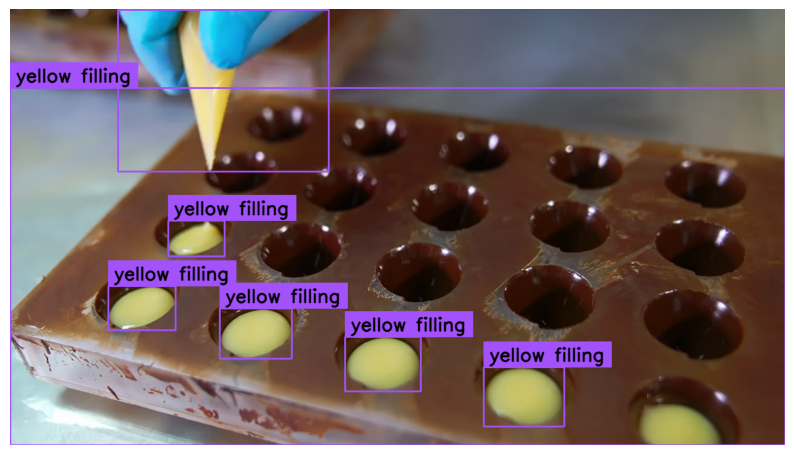

In [39]:
annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## Saving Detections 

Now, at the end of the day would you like to see the final results and show to your supervisor all the metrics, but for that you need to save each of the prediction and after that you can create reports with the data.

We can use `sv.CSVSink` to save predictions. CSVSink allow to pass custom data alongside the detection fields, providing flexibility for logging various types of information.


On the other hand, by using [`sv.Detections.area`](https://supervision.roboflow.com/develop/detection/core/#supervision.detection.core.Detections.area) property, we can learn the area of each individual bounding box.

In [45]:
results = model.infer(frame, confidence=0.002)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

csv_sink = sv.CSVSink('detections.csv')


array([ 7.5408e+05,       92844,       11255,       12969,      9875.9,      8007.7,      5433.5])

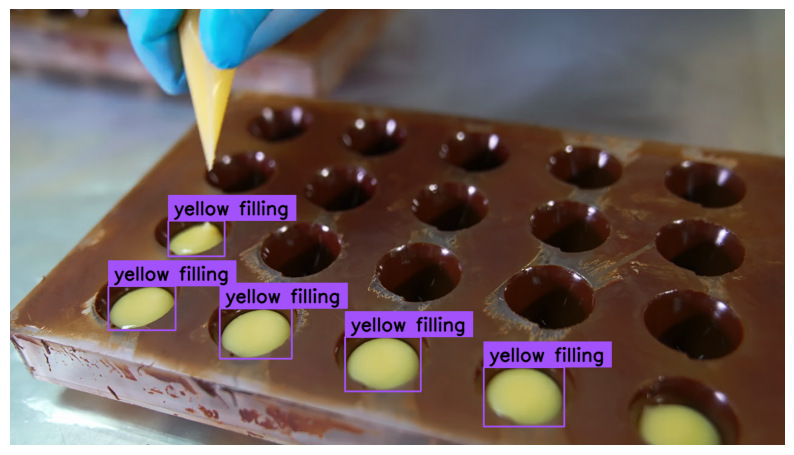

In [47]:
annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
csv_sink.append(detections, custom_data={'frame_number': "x"})
sv.plot_image(annotated_image, (10, 10))

Show CSV save it in local 

## Final Result

Finally, we are ready to process our entire video. Now in truth we can appreciate the speed of YOLO-World.

In [49]:
TARGET_VIDEO_PATH = f"{HOME}/test_demo1.mp4

In [50]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
csv_sink = sv.CSVSink('detections.csv')


with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink, csv_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        results = model.infer(frame, confidence=0.002)
        detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

        annotated_frame = frame.copy()
        annotated_frame = BOUNDING_BOX_ANNOTATOR.annotate(annotated_frame, detections)
        annotated_frame = LABEL_ANNOTATOR.annotate(annotated_frame, detections)
        sink.write_frame(annotated_frame)
        csv_sink.append(detections, custom_data={'frame_number': "x"})

100%|██████████| 442/442 [00:31<00:00, 13.90it/s]


 Keep in mind that the video preview below works only in the web version of the cookbooks and not in Google Colab.

<video controls>
    <source
        src="https://storage.googleapis.com/com-roboflow-marketing/supervision/cookbooks/yellow-filling-output-1280x720.mp4"
        type="video/mp4"
    >
</video>